In [1]:
#import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import seaborn as sns

In [2]:
dateparser = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
dataset = pd.read_csv('C:/Faculta anul 3 sem 2/Licenta/DJIA/PG.csv', sep=',', index_col = 'Date', parse_dates = ['Date'], date_parser = dateparser).fillna(0)
dataset.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,91.930000,90.550003,91.919998,90.650002,7558900.0,82.092216
2018-01-03,91.089996,90.519997,90.730003,90.540001,5863600.0,81.992599
2018-01-04,91.769997,90.610001,90.830002,91.180000,6322500.0,82.572166
2018-01-05,91.300003,90.570000,91.269997,91.239998,5949700.0,82.626526
2018-01-08,91.769997,90.930000,90.930000,91.720001,4860700.0,83.061218


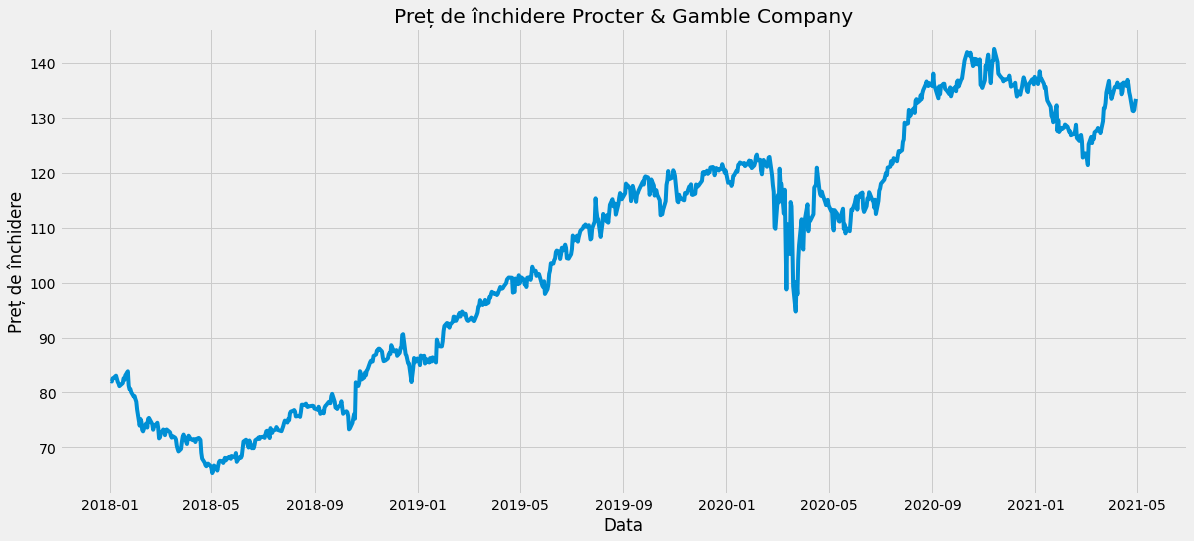

In [3]:
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.plot(dataset['Adj Close'])
plt.title('Preț de închidere Procter & Gamble Company')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

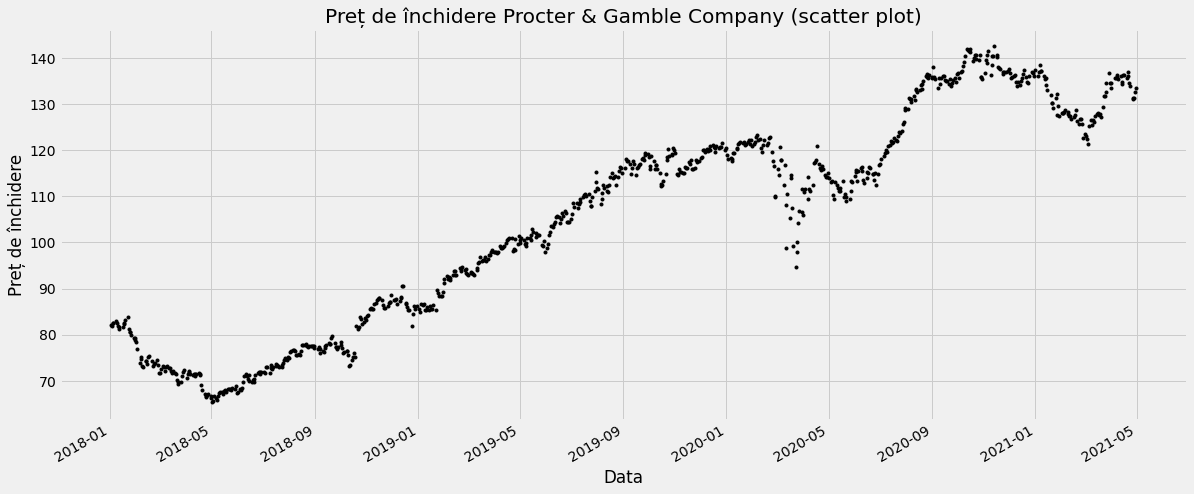

In [4]:
df_close = dataset['Adj Close']
df_close.plot(style='k.')
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.title('Preț de închidere Procter & Gamble Company (scatter plot)')
plt.show

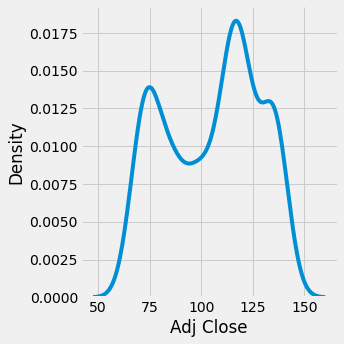

In [5]:
density = sns.displot(dataset, x="Adj Close", kind="kde")

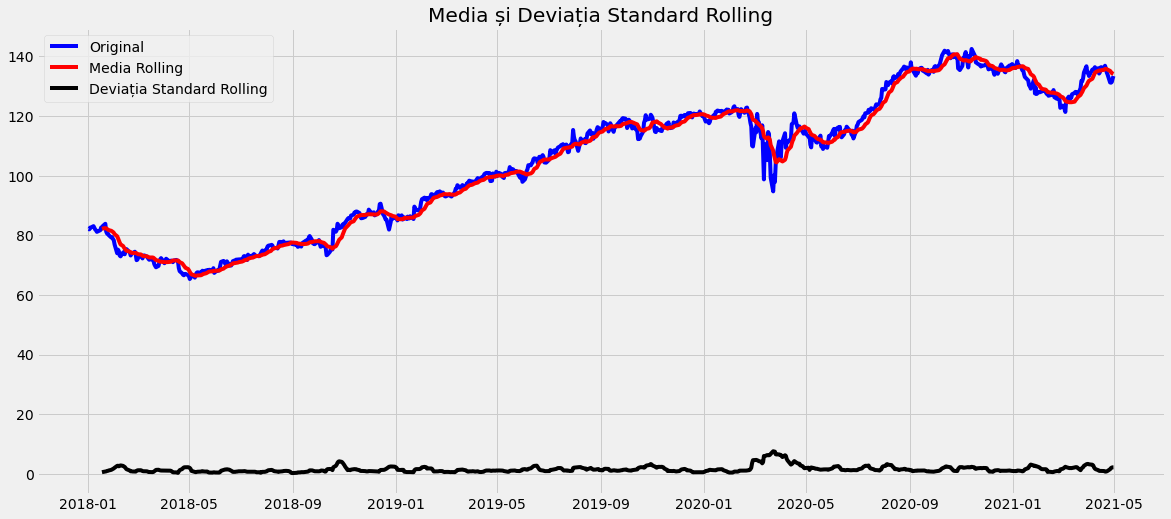

Rezultatele testului Dickey-Fuller Augmentat: 
Test statistic            -0.615913
p-value                    0.867346
Nr. decalaje folosite      9.000000
Nr. observatii           828.000000
valoare critica (1%)      -3.438272
valoare critica (5%)      -2.865037
valoare critica (10%)     -2.568632
dtype: float64


In [6]:
def test_stationarity(timeseries):
    rolling_mean = timeseries.rolling(12).mean()
    rolling_std = timeseries.rolling(12).std()
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolling_mean, color = 'red', label='Media Rolling')
    plt.plot(rolling_std, color = 'black', label = 'Deviația Standard Rolling')
    plt.legend(loc='best')
    plt.title('Media și Deviația Standard Rolling')
    plt.show(block=False)
    
    print('Rezultatele testului Dickey-Fuller Augmentat: ')
    adft = adfuller(timeseries, autolag = 'AIC')
    results = pd.Series(adft[0:4],index=['Test statistic','p-value','Nr. decalaje folosite','Nr. observatii'])
    for key, value in adft[4].items():
        results['valoare critica (%s)' %key] = value
    print(results)
test_stationarity(df_close)

<Figure size 1296x576 with 0 Axes>

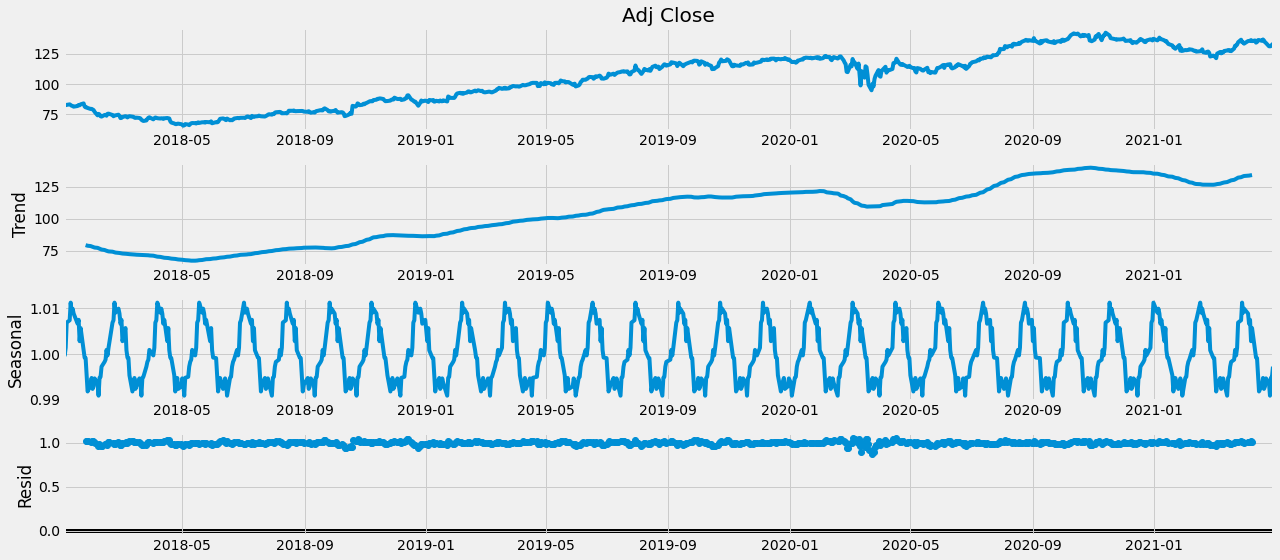

In [7]:
result = seasonal_decompose(df_close, model='multiplicative',freq = 30)
fig = plt.figure()
fig = result.plot()

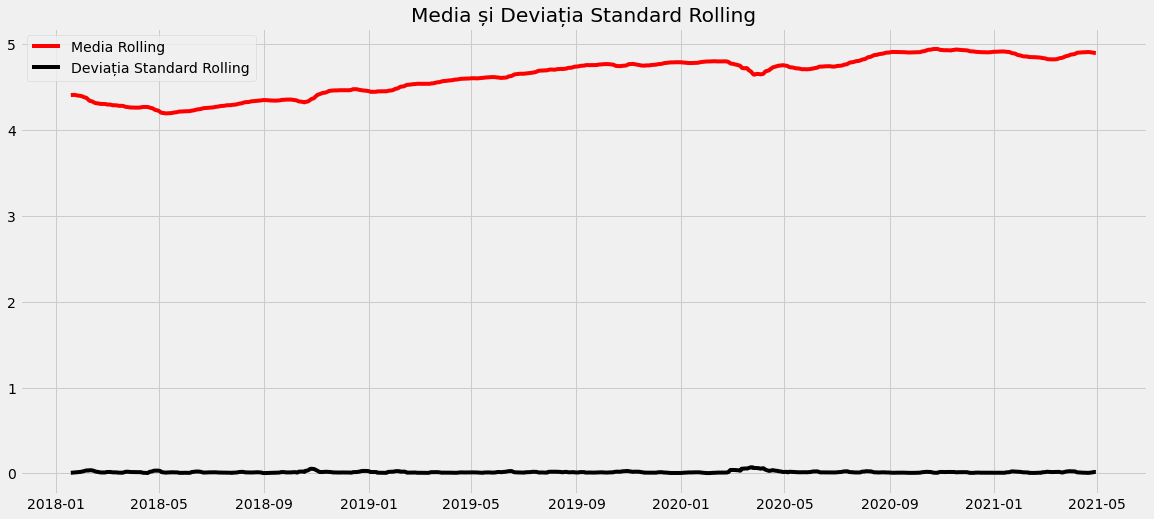

In [8]:
df_log = np.log(df_close)
rolling_mean = df_log.rolling(12).mean()
rolling_std = df_log.rolling(12).std()
plt.title('Media și Deviația Standard Rolling')
plt.plot(rolling_mean, color = 'red', label='Media Rolling')
plt.plot(rolling_std, color = 'black', label = 'Deviația Standard Rolling')
plt.legend(loc='best')
plt.show()

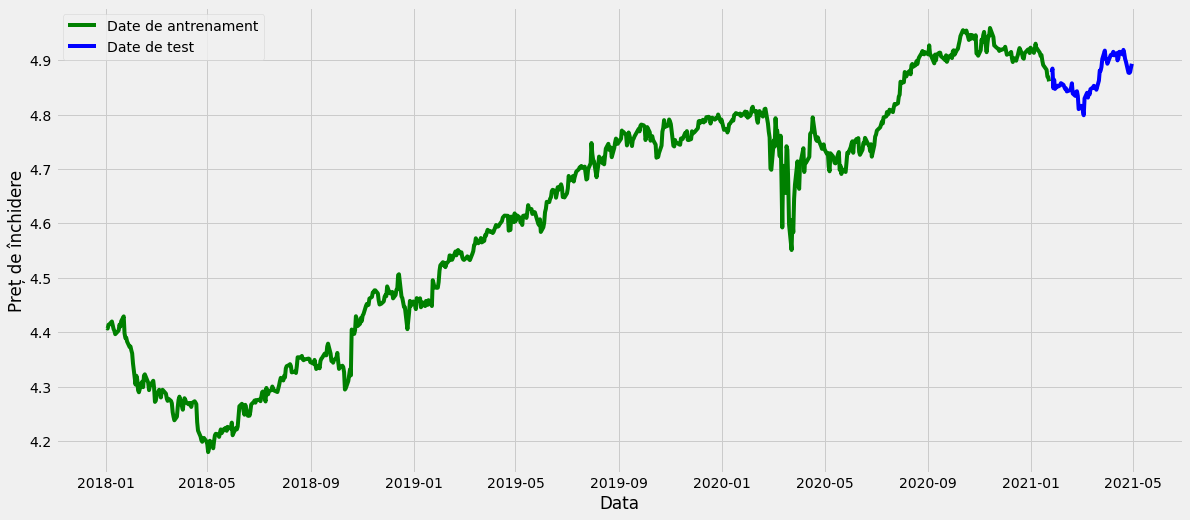

In [9]:
train_data, test_data = df_log[:int(len(df_log)*0.92)], df_log[int(len(df_log)*0.92):]
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.plot(train_data, 'green', label = "Date de antrenament")
plt.plot(test_data, 'blue', label = "Date de test")
plt.legend()

In [10]:
auto_ARIMA = auto_arima(train_data,
                        start_p=0, start_q=0,
                        test = 'adf',
                        max_p=3, max_q=3,
                        m=1,
                        d=None,
                        seasonal=True,
                        start_P=0, 
                        D=0,
                        trace=True,
                        error_action = 'ignore',
                        suppress_warnings=True,
                        stepwise=True,)
print(auto_ARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4288.338, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4301.520, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4301.332, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4289.126, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4299.540, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4299.552, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4297.521, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4301.910, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4299.950, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4299.968, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4301.660, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4297.922, Time=0.61 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.912 seconds
                               SARIMAX Results                              

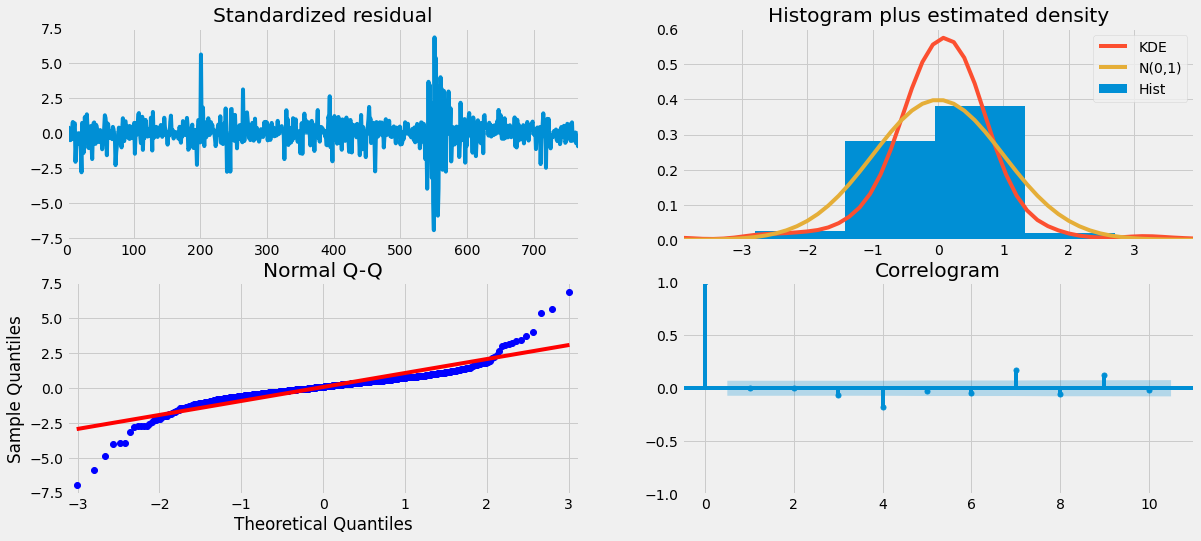

In [11]:
auto_ARIMA.plot_diagnostics()
plt.show()

In [12]:
warnings.filterwarnings('ignore')
model = ARIMA(train_data, order=(1, 1, 0))  
fitted = model.fit(disp=-1,trend=  'nc')  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                  769
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2152.955
Method:                       css-mle   S.D. of innovations              0.015
Date:                Tue, 15 Jun 2021   AIC                          -4301.910
Time:                        10:41:41   BIC                          -4292.620
Sample:                             1   HQIC                         -4298.335
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.D.Adj Close    -0.1379      0.036     -3.864      0.000      -0.208      -0.068
                                    Roots                                    
                  Real          

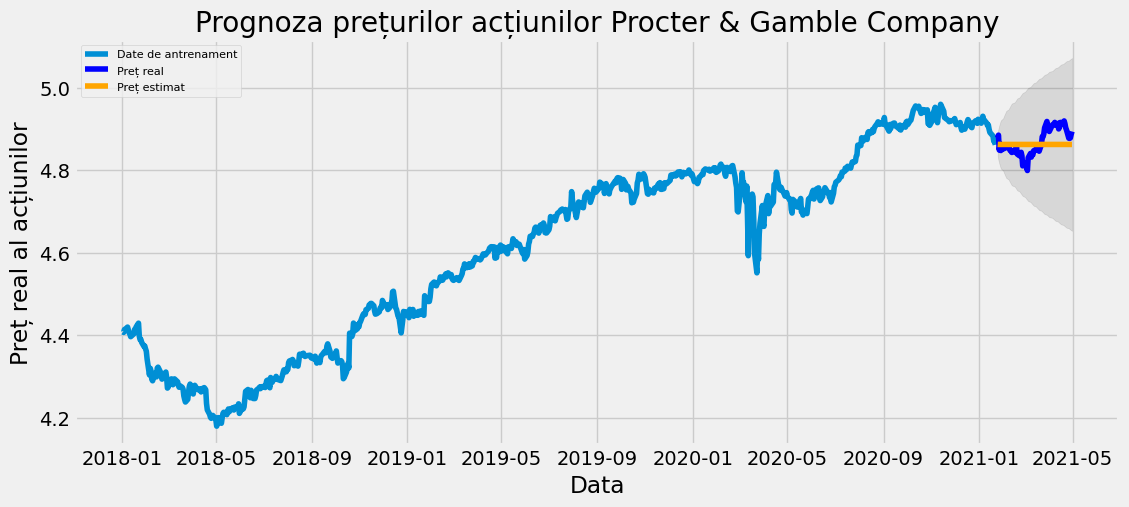

In [13]:
fc, se, conf = fitted.forecast(68, alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Date de antrenament')
plt.plot(test_data, color = 'blue', label='Preț real')
plt.plot(fc_series, color = 'orange',label='Preț estimat')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('Prognoza prețurilor acțiunilor Procter & Gamble Company')
plt.xlabel('Data')
plt.ylabel('Preț real al acțiunilor')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [15]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: '+str(mse))
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))*100
print('MAPE: '+str(mape))

MSE: 17.93248669347924
MAE: 3.6135473775997666
RMSE: 4.23467669291048
MAPE: 2.7595987302417444
